# Clustering Crypto

### Unit 13 - Option 2 - Gregory Terrinoni

In [201]:
# Initial imports
import requests
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [202]:
# Fetching coin data from CryptoCompare
#url = "https://min-api.cryptocompare.com/data/all/coinlist"
#response = requests.get(url)
#data = response.json()

In [203]:
# Creating a DataFrame from raw data
#raw_data = data['Data']
#crypto_df = pd.DataFrame.from_dict(raw_data).T

In [204]:
 # Reading in csv file:
file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
crypto_df = pd.read_csv(file_path, index_col=0)

### Data Preprocessing

In [205]:
# Selecting relevant columns
crypto_df = crypto_df[['CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply']]
# Further cleaning of data and changing dtypes
crypto_df["TotalCoinSupply"] = crypto_df["TotalCoinSupply"].str.replace(" ","")
crypto_df["TotalCoinSupply"] = crypto_df["TotalCoinSupply"].str.replace("10.500.000","10500000")
crypto_df["TotalCoinSupply"] = crypto_df["TotalCoinSupply"].str.replace("1.000.000","1000000")
crypto_df["TotalCoinSupply"] = crypto_df["TotalCoinSupply"].astype(float)

In [206]:
# Selecting only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df['IsTrading'] == True] 
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,4.200000e+01
365,365Coin,X11,True,PoW/PoS,NaN,2.300000e+09
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,5.320000e+08
611,SixEleven,SHA-256,True,PoW,NaN,6.110000e+05
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0.000000e+00


In [207]:
# Selecting only cryptocurrencies with a working algorithm
crypto_df = crypto_df[crypto_df['Algorithm'] != 'N/A']
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,4.200000e+01
365,365Coin,X11,True,PoW/PoS,NaN,2.300000e+09
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,5.320000e+08
611,SixEleven,SHA-256,True,PoW,NaN,6.110000e+05
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0.000000e+00


In [208]:
# Removing the "IsTrading" column
crypto_df = crypto_df.drop("IsTrading", 1)
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
365,365Coin,X11,PoW/PoS,NaN,2.300000e+09
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
611,SixEleven,SHA-256,PoW,NaN,6.110000e+05
808,808,SHA-256,PoW/PoS,0.000000e+00,0.000000e+00


In [209]:
# Removing rows with at least 1 null value
crypto_df = crypto_df.dropna(thresh=1)
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
365,365Coin,X11,PoW/PoS,NaN,2.300000e+09
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
611,SixEleven,SHA-256,PoW,NaN,6.110000e+05
808,808,SHA-256,PoW/PoS,0.000000e+00,0.000000e+00


In [210]:
# Removing rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df['TotalCoinsMined'] > 0]
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,3.141593e+11
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,2.100000e+07
ETH,Ethereum,Ethash,PoW,1.076842e+08,0.000000e+00


In [211]:
# Dropping rows where there are 'N/A' text values
crypto_df = crypto_df[(crypto_df != 'N/A').all(axis=1)]

In [212]:
# Storing the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coins_name = crypto_df[["CoinName"]]
coins_name.head()

,CoinName
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum


In [213]:
# Dropping the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df = crypto_df.drop("CoinName", 1)
crypto_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
404,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
1337,X13,PoW/PoS,2.927942e+10,3.141593e+11
BTC,SHA-256,PoW,1.792718e+07,2.100000e+07
ETH,Ethash,PoW,1.076842e+08,0.000000e+00


In [214]:
# Creating dummy variables for text features
X = pd.get_dummies(crypto_df)
X.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,4.200000e+01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,5.320000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,3.141593e+11,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0.000000e+00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [215]:
# Standardizing data
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

### Reducing Dimensions Using PCA

In [216]:
# Using PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(X_scaled)

In [217]:
# Creating a DataFrame with the principal components data
df_crypto_pca = pd.DataFrame(
                        data=crypto_pca, 
                        columns=["PC 1", "PC 2", "PC 3"],
                        index = crypto_df.index
                        )
df_crypto_pca.head(10)

,PC 1,PC 2,PC 3
42,-0.249655,1.180023,-0.443155
404,-0.231506,1.179958,-0.443171
1337,3.367898,1.925363,-0.481329
BTC,-0.206276,-1.362730,0.155050
ETH,-0.240556,-2.035828,0.276871
LTC,-0.198322,-1.072354,-0.018851
DASH,-0.324650,1.339539,-0.399158
XMR,-0.237356,-2.278097,0.277219
ETC,-0.238360,-2.035843,0.276860
ZEC,-0.235844,-2.091083,0.280992


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [218]:
# Initializing inertia list and setting a range
inertia = []
k = list(range(1, 11))

# Calculating the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_crypto_pca)
    inertia.append(km.inertia_)

# Creating the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [219]:
# Initializing the K-Means model
model = KMeans(n_clusters=4, random_state=0)
# Fitting the model
model.fit(df_crypto_pca)
# Predicting clusters
predictions = model.predict(df_crypto_pca)
# Creating a new DataFrame including predicted clusters and cryptocurrencies features
df_crypto_pca["class"] = model.labels_
clustered_df = crypto_df.join(df_crypto_pca)
clustered_df["CoinName"] = coins_name
clustered_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,class,CoinName
42,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01,-0.249655,1.180023,-0.443155,0,42 Coin
404,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08,-0.231506,1.179958,-0.443171,0,404Coin
1337,X13,PoW/PoS,2.927942e+10,3.141593e+11,3.367898,1.925363,-0.481329,0,EliteCoin
BTC,SHA-256,PoW,1.792718e+07,2.100000e+07,-0.206276,-1.362730,0.155050,1,Bitcoin
ETH,Ethash,PoW,1.076842e+08,0.000000e+00,-0.240556,-2.035828,0.276871,1,Ethereum


### Visualizing Results

#### 3D-Scatter with Clusters

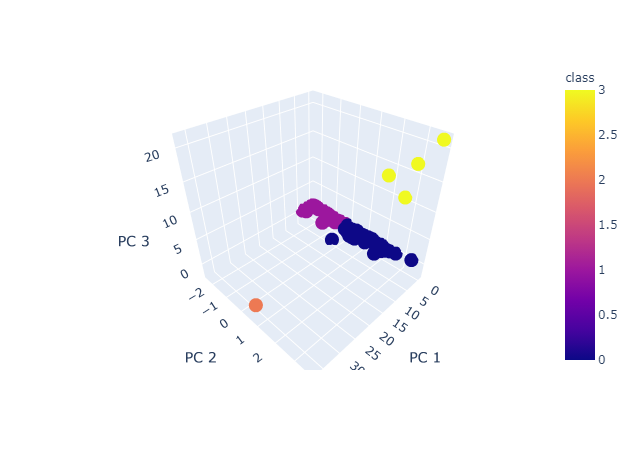

In [220]:
# Creating a 3D-Scatter with the PCA data and the clusters
px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color = 'class',
    hover_name="CoinName",
    hover_data=["Algorithm"]
)

#### Table of Tradable Cryptocurrencies

In [221]:
# Creating a table with tradable cryptos
clustered_df.hvplot.table(columns=["CoinName", "Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "class"], sortable=True, selectable=True)

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,class]

In [222]:
# Printing the total number of tradable cryptocurrencies
tradeable_crypto = (len(clustered_df))
print(f'The number of tradeable cryptocurrencies is {tradeable_crypto}!')

The number of tradeable cryptocurrencies is 532!


#### Scatter Plot with Tradable Cryptocurrencies

In [227]:
# Scaling data to create the scatter plot
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
data_scaled = scaler.fit_transform(crypto_df[["TotalCoinsMined", "TotalCoinSupply"]])

# Creating dataframe for plotting
scaled_data = pd.DataFrame(data_scaled, columns=["TotalCoinsMined", "TotalCoinSupply"])
scaled_data["CoinName"] = clustered_df.index
scaled_data.head()

,TotalCoinsMined,TotalCoinSupply,CoinName
0,0.000000,4.242424e-11,42
1,0.001066,5.373737e-04,404
2,0.029576,3.173326e-01,1337
3,0.000018,2.121212e-05,BTC
4,0.000109,0.000000e+00,ETH


In [228]:
# Plotting the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
scaled_data.hvplot.scatter(
    x="TotalCoinsMined",
    y="TotalCoinSupply",
    hover_cols=["CoinName"]
)

:Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)